In [1]:
MEAS_COLUMNS = [
    "TI-19",
    "FI-16",
    "TI-33",
    "FI-2",
    "FI-151",
    "TI-8",
    "FI-241",
    "valve-position-12",  # dry-bed
    "FI-38",  # stripper
    "PI-28",  # stripper
    "TI-28",  # stripper
    "FI-20",
    "FI-30",
    "TI-3",
    "FI-19",
    "FI-211",
    "FI-11",
    "TI-30",
    "PI-30",
    "TI-1213",
    "TI-4",
    "FI-23",
    "delta_t",
]

In [9]:
import pandas as pd 
from darts import TimeSeries

In [33]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.model.scaler import Scaler
from pyprocessta.preprocess.resample import resample_regular
import joblib

In [5]:
df = pd.read_pickle('df_dropped.pkl')
df = resample_regular(df, '5min')

In [6]:
df.to_pickle('df_dropped_5min_resampled.pkl')

In [12]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [13]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [16]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [17]:
model = run_model((x,y))

/home/kjablonk/anaconda3/envs/timeseries_analysis/lib/python3.8/site-packages/torch/random.py:95: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(
[2021-04-26 14:30:46,542] INFO | darts.models.torch_forecasting_model | Train dataset contains 6121 samples.
[2021-04-26 14:30:46,542] IN

In [29]:
backtest = model.historical_forecasts(y,
                          covariates=x,
                          start=0.01,
                          forecast_horizon=1,
                          stride=2,
                          retrain=False,
                          verbose=False)

In [25]:
import matplotlib.pyplot as plt

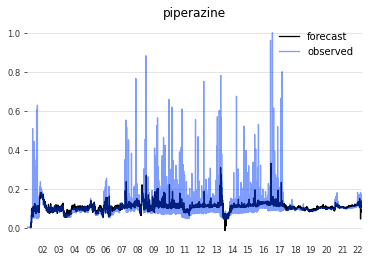

In [31]:
backtest['1'].plot(label='forecast')
y['1'].plot(alpha=.5, label='observed')
plt.xticks([], [])
plt.legend()
plt.title('piperazine')
plt.savefig('piperazine_forecast.pdf', bbox_inches='tight')

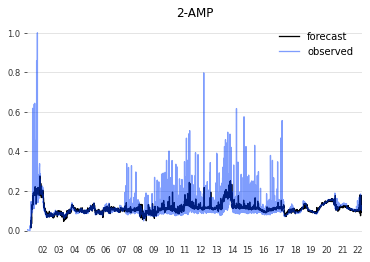

In [32]:
backtest['0'].plot(label='forecast')
y['0'].plot(alpha=.5, label='observed')
plt.xticks([], [])
plt.legend()
plt.title('2-AMP')
plt.savefig('amp_forecast.pdf', bbox_inches='tight')

In [35]:
joblib.dump(model, '2amp_pip_model')
joblib.dump(transformer, 'x_scaler')
joblib.dump(y_transformer, 'y_transformer_2amp_pip')

['y_transformer_2amp_pip']

## Now, also build a model for CO2 and NH3

In [36]:
NEW_TARGETS = ["Carbon dioxide CO2", "Ammonia NH3"]

In [37]:
y = TimeSeries.from_dataframe(df, value_cols=NEW_TARGETS)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [38]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [39]:
model_co2 = run_model((x,y))

[2021-04-26 14:51:40,411] INFO | darts.models.torch_forecasting_model | Train dataset contains 6121 samples.
[2021-04-26 14:51:40,411] INFO | darts.models.torch_forecasting_model | Train dataset contains 6121 samples.


In [40]:
backtest_c02 = model_co2.historical_forecasts(y,
                          covariates=x,
                          start=0.01,
                          forecast_horizon=1,
                          stride=2,
                          retrain=False,
                          verbose=False)

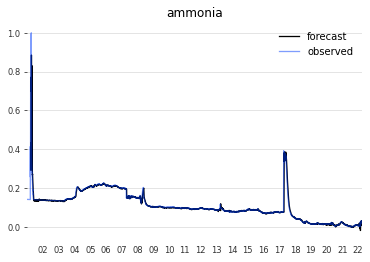

In [42]:
backtest_c02['1'].plot(label='forecast')
y['1'].plot(alpha=.5, label='observed')
plt.xticks([], [])
plt.legend()
plt.title('ammonia')
plt.savefig('ammonia_forecast.pdf', bbox_inches='tight')

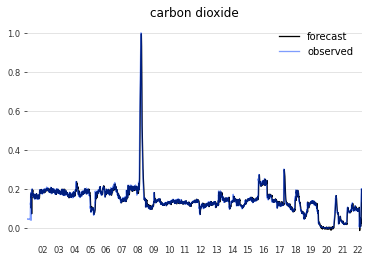

In [44]:
backtest_c02['0'].plot(label='forecast')
y['0'].plot(alpha=.5, label='observed')
plt.xticks([], [])
plt.legend()
plt.title('carbon dioxide')
plt.savefig('co2_forecast.pdf', bbox_inches='tight')

In [45]:
joblib.dump(model_co2, 'co2_ammonia_model')
joblib.dump(y_transformer, 'y_transformer_co2_ammonia')

['y_transformer_co2_ammonia']